In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics

In [73]:
train = pd.read_csv("../input/train_.csv")
dev = pd.read_csv("../input/dev.csv")
test = pd.read_csv("../input/test.csv")

In [74]:
dev.groupby("target").count()["qid"]

target
0    9416
1     584
Name: qid, dtype: int64

In [ ]:
def tokenize(text):
    words = jieba.cut(text)
    return [w for w in words]
tfidf_model = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, max_df=0.8, 
                      strip_accents="unicode", use_idf=1, smooth_idf=1, sublinear_tf=1)
tfidf_model.fit(train.question_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words=None, strip_accents='unicode', sublinear_tf=1,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7fd109f26d08>, use_idf=1,
        vocabulary=None)

In [ ]:
trn_term_doc = tfidf_model.transform(train.question_text)
dev_term_doc = tfidf_model.transform(dev.question_text)
test_term_doc = tfidf_model.transform(test.question_text)

In [ ]:
def pr(y_i, x, y):
    
    a = x[y==y_i].sum(0)
    b = np.sum(y==y_i)
    return (a+1) / (b+1)

def get_mdl(x, y, mdl):
    r = np.log(pr(1,x,y)/pr(0,x,y))
    x = x.multiply(r)
    mdl.fit(x,y)
    return mdl, r


lr, r = get_mdl(trn_term_doc, train.target.values, LogisticRegression(C=0.5, solver="lbfgs", penalty="l2", 
                                                                      class_weight={
                                                                          1:0.7,
                                                                          0:0.3
                                                                      }))


/data1/songbohan/anaconda3/envs/reinforce_learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
dev["prediction"] = lr.predict(dev_term_doc.multiply(r))
train["prediction"] = lr.predict(trn_term_doc.multiply(r))

In [115]:
def show(dev):
    print(confusion_matrix(y_pred=dev.prediction, y_true=dev.target))
    print(metrics.f1_score(y_pred=dev.prediction, y_true=dev.target))
    print(classification_report(y_pred=dev.prediction, y_true=dev.target))
show(train)
show(dev)

[[1121180   94716]
 [   4439   75787]]
0.604533181243
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1215896
           1       0.44      0.94      0.60     80226

   micro avg       0.92      0.92      0.92   1296122
   macro avg       0.72      0.93      0.78   1296122
weighted avg       0.96      0.92      0.94   1296122

[[9290  126]
 [ 327  257]]
0.531540847983
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9416
           1       0.67      0.44      0.53       584

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.82      0.71      0.75     10000
weighted avg       0.95      0.95      0.95     10000



In [136]:
res = lr.predict_proba(X=dev_term_doc.multiply(r))
fpr, tpr, thresholds = metrics.roc_curve(dev["target"], res[:,1])

In [137]:
def search_threshold(thresholds):
    max_f1, max_thre = 0., 0.
    for threshold in thresholds:
        res = lr.predict_proba(dev_term_doc.multiply(r))[:,1]
        dev["pred"] = np.asarray(res > threshold, np.int64)
        f1 = metrics.f1_score(y_pred=dev["pred"], y_true=dev["target"])
        if max_f1 < f1:
            max_f1, max_thre = f1, threshold
            
    return max_f1, max_thre

In [ ]:
_, opt_thre = search_threshold(thresholds)

/data1/songbohan/anaconda3/envs/reinforce_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


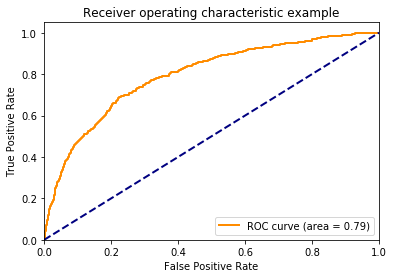

In [131]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [118]:
show(train)
show(dev)

[[1203580   12316]
 [  40327   39899]]
0.602517347347
              precision    recall  f1-score   support

           0       0.97      0.99      0.98   1215896
           1       0.76      0.50      0.60     80226

   micro avg       0.96      0.96      0.96   1296122
   macro avg       0.87      0.74      0.79   1296122
weighted avg       0.95      0.96      0.96   1296122

[[9290  126]
 [ 327  257]]
0.531540847983
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9416
           1       0.67      0.44      0.53       584

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.82      0.71      0.75     10000
weighted avg       0.95      0.95      0.95     10000



In [121]:
show(train)
show(dev)

[[1188652   27244]
 [  28026   52200]]
0.65384856266
              precision    recall  f1-score   support

           0       0.98      0.98      0.98   1215896
           1       0.66      0.65      0.65     80226

   micro avg       0.96      0.96      0.96   1296122
   macro avg       0.82      0.81      0.82   1296122
weighted avg       0.96      0.96      0.96   1296122

[[9290  126]
 [ 327  257]]
0.531540847983
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9416
           1       0.67      0.44      0.53       584

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.82      0.71      0.75     10000
weighted avg       0.95      0.95      0.95     10000



In [123]:
dev[(dev["prediction"]!=dev["target"])& (dev["target"] == 1)]

,qid,question_text,target,prediction
34,bb5bc7c7ccc578c63680,Are you hungry?,1,0
39,3cd33bd002a459f5b17c,Are Kashmiris egoistic?,1,0
59,981eb399b060b8a21c9a,What should I do if my girlfriend keeps catchi...,1,0
182,047c50cc46f674b5998f,Can 42 old bribed white men sign a bill that l...,1,0
208,a27552aba51200f56a06,Even Pranab Mukherjee abused our hero Rajdeep ...,1,0
250,1135cbc5eb045bbb2258,I can read minds of people around me. And even...,1,0
269,4eed0d9c98640d57e695,Is The Donald going to nuke Kimmy Jing-Jong?,1,0
352,518c14b0ef5da6d110ed,Why was Adolf Hitler the greatest man who ever...,1,0
386,04dd8de8cd2c2c403010,Would you say its better to win money or to ea...,1,0
387,572c9fe445449a48d2cd,Would the world be at peace if the US didn't e...,1,0


In [59]:
sample_subbmition = pd.read_csv("../data/sample_submission.csv")

In [143]:
def submit(x, model):
    test_x = x.multiply(r)
    test = sample_subbmition.copy()
    proba = model.predict_proba(test_x)[:,1]
    test.prediction = np.asarray(proba > opt_thre, np.int64)
    return test

In [144]:
test = submit(test_term_doc, lr)

In [64]:
test.groupby("prediction").count()["qid"]

prediction
0    54151
1     2219
Name: qid, dtype: int64

In [146]:
test.groupby("prediction").count()["qid"]

prediction
0    52056
1     4314
Name: qid, dtype: int64

In [147]:
test.to_csv("submission.csv", index=False)